In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

In [2]:
x_train = pd.read_csv('x_train.csv')
x_test = pd.read_csv('x_test.csv')
y_train = pd.read_csv('y_train.csv')

data = pd.concat( [x_train, y_train], axis=1 ).drop([2583, 2584, 2586, 2587, 2622]) # drop few outliers
data.head()

,m,k,n,cacheL1IsShared,cacheL1Size,cacheL2IsShared,cacheL2Size,cacheL3IsShared,cacheL3Size,cacheL1Threads,...,SeqCopy_16MB_by256,SeqCopy_20MB_by256,SeqCopy_21MB_by256,SeqCopy_32MB_by256,SeqCopy_48MB_by256,SeqCopy_64MB_by256,SeqCopy_72MB_by256,SeqCopy_96MB_by256,SeqCopy_128MB_by256,time
0,2500,3500,5000,0,32,0,256,1,10240,2,...,5871.6,5454.5,5201.8,5236.4,5724.8,5236.4,5236.4,6165.1,5120.0,1.016325
1,2500,4000,4500,0,32,0,256,1,10240,2,...,5871.6,5454.5,5201.8,5236.4,5724.8,5236.4,5236.4,6165.1,5120.0,1.108012
2,2500,4000,5000,0,32,0,256,1,10240,2,...,5871.6,5454.5,5201.8,5236.4,5724.8,5236.4,5236.4,6165.1,5120.0,1.388898
3,2500,4500,5000,0,32,0,256,1,10240,2,...,5871.6,5454.5,5201.8,5236.4,5724.8,5236.4,5236.4,6165.1,5120.0,1.368330
4,2500,5000,5000,0,32,0,256,1,10240,2,...,5871.6,5454.5,5201.8,5236.4,5724.8,5236.4,5236.4,6165.1,5120.0,1.496602


## Algorithm outline

- Group data by system parameters. There are 92 groups, which are the same for train and test set.
- Fit a Linear Regression (see details below) for each group using matrix size as features, so there are 92 regressors.
- To make a prediction, select a group by system parameters and use corresponding regressor.

In [3]:
features = x_train.columns[:3].tolist() # 'm', 'k' and 'n' are features used to fit the regression
system_params = x_train.columns[3:].tolist() # other columns define system parameters

data_grouped = data.groupby(system_params)
systems = pd.DataFrame([n for n, g in data_grouped], columns=system_params)

## Linear regression details

Consider a design matrix $\pmb X$ consisting of $N$ training examples $x^{(i)} = 
\begin{pmatrix}
m^{(i)} & k^{(i)} & n^{(i)}
\end{pmatrix}$.

Assume the following model:

$$\hat y_\theta = \theta_0 \, m^{\theta_1} k^{\theta_2} n^{\theta_3}$$

If we take a logarithm, we can rewrite this as 

$$\log \hat y_\theta = \log \theta_0 + \theta_1 \log m + \theta_2 \log k + \theta_3 \log n = \log \pmb X \cdot \pmb\theta + intercept,$$

so we have a linear regression between $\log \hat y_\theta$ and $\log \pmb X$ with respect to parameters vector $\pmb\theta$ and intercept term.

Instead of ordinary least squares, let's take a MRE as objective function:

$$
J(\theta) = 
\frac1N \sum\limits_{i=1}^N \left| \frac{ \hat y_\theta^{(i)} - y^{(i)} }{y^{(i)}} \right| = 
\frac1N \sum\limits_{i=1}^N \left| \frac{\hat y_\theta^{(i)}}{y^{(i)}} - 1 \right| = 
\frac1N \sum\limits_{i=1}^N \left| e ^ {\displaystyle \log \hat y_\theta^{(i)} - \log y^{(i)}} - 1 \right| =
\frac1N \sum\limits_{i=1}^N \left| e ^ {\displaystyle \log \pmb X^{(i)} \cdot \pmb\theta + intercept - \log y^{(i)}} - 1 \right| \to \min\limits_\theta
$$

This function is non-convex and hard to minimize, but good results can be obtained using Nelder-Mead method with initial guess $\pmb\theta_{init} = \pmb 1$, $intercept_{init} = \frac1N \sum\limits_{i=1}^N \left( \log y^{(i)} - \log \pmb X^{(i)} \cdot \pmb\theta \right)$, which comes from OLS-solution for $\hat y_\theta = \theta \, m k n$.

In [4]:
class MRELogLinearRegression:
    def _errFunc(self, C, X, y):
        return np.mean( np.abs(np.exp( np.log(X).dot(C[:-1]) + C[-1] - np.log(y) ) - 1) )
    
    def fit(self, X, y):
        Cinit = np.ones((X.shape[1] + 1,))
        Cinit[-1] = np.mean( np.log(y) - np.log(X).dot(Cinit[:-1]) )
        self.C = minimize(self._errFunc,
                          Cinit,
                          (X, y),
                          method='Nelder-Mead').x
        
    def predict(self, X):
        return np.exp( np.log(X).dot(self.C[:-1]) + self.C[-1] )
    
    def MREscore(self, X, y):
        return np.mean( np.abs( self.predict(X) - y ) / y )

[90 65 85  0 89 72 71  6 77  2 67 87  4 83 79 68 70 91 30 48  1 69 75 43 78
 57 36 44 66 53  5  3 16 23 54 74 13 45 61 11 76  7 49 52 50 31 28 60 82 10
 14 17 55 38 18 21 25 73 62  9 58 34 88 32  8 46 51 22 15 40 35 12 56 33 63
 20 37 29 64 81 24 39 27 86 41 19 42 80 47 26 84 59]


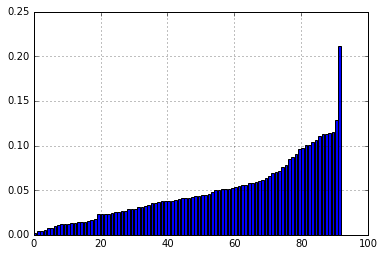

In [5]:
regressors = {}
errors = []
for n, g in data_grouped: 
    rgr = MRELogLinearRegression()
    rgr.fit(g[features].values, g.time.values)
    regressors[n] = rgr
    errors.append( rgr.MREscore(g[features].values, g.time.values) )
systems['error'] = errors
print(np.argsort(errors))
plt.bar(range(len(errors)), np.sort(errors))
plt.grid()

In [6]:
y_train_pred = x_train.apply(lambda x: regressors[tuple(x[system_params])].predict(x[features].astype('float64').values), axis=1)
np.mean(np.abs(y_train_pred - y_train.time) / y_train.time)

0.049787215146016243

In [7]:
y_test_pred = x_test.apply(lambda x: regressors[tuple(x[system_params])].predict(x[features].astype('float64').values), axis=1)
y_test_pred.to_csv('log-metric-linear-regression-m-k-n', index=False)